This is about incorrect treatment of models here: 
https://machinelearningmastery.com/lasso-regression-with-python/

Issues: no standardisation, alpha search is weird

# Environment

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score, get_scorer

from sklearn.linear_model import Lasso, Ridge, LassoCV, LinearRegression

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_validate, train_test_split

In [4]:
my_random_state = 12345

In [5]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 
                'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = pd.read_csv("../datasets/housing.csv", 
                header=None, delimiter=r"\s+", names=column_names)

In [6]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [7]:
y = data['MEDV']
X = data.drop(['MEDV'], axis = 1)

In [8]:
sc = StandardScaler()

X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(data = X_scaled, columns = X.columns)

In [9]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [17]:
def regmodel_param_plot(
    validation_score, train_score, alphas_to_try, chosen_alpha,
    scoring, model_name, test_score = None, filename = None):
    
    plt.figure(figsize = (8,8))
    sns.lineplot(y = validation_score, x = alphas_to_try, 
                 label = 'validation_data')
    sns.lineplot(y = train_score, x = alphas_to_try, 
                 label = 'training_data')
    plt.axvline(x=chosen_alpha, linestyle='--')
    if test_score is not None:
        sns.lineplot(y = test_score, x = alphas_to_try, 
                     label = 'test_data')
    plt.xlabel('alpha_parameter')
    plt.ylabel(scoring)
    plt.title(model_name + ' Regularisation')
    plt.legend()
    if filename is not None:
        plt.savefig(str(filename) + ".png")
    plt.show()

In [16]:
def regmodel_param_test(
    alphas_to_try, X, y, cv, scoring = 'r2', 
    model_name = 'LASSO', X_test = None, y_test = None, 
    draw_plot = False, filename = None):
    
    validation_scores = []
    train_scores = []
    results_list = []
    if X_test is not None:
        test_scores = []
        scorer = get_scorer(scoring)
    else:
        test_scores = None

    for curr_alpha in alphas_to_try:
        
        if model_name == 'LASSO':
            regmodel = Lasso(alpha = curr_alpha)
        elif model_name == 'Ridge':
            regmodel = Ridge(alpha = curr_alpha)
        else:
            return None

        results = cross_validate(
            regmodel, X, y, scoring=scoring, cv=cv, 
            return_train_score = True)

        validation_scores.append(np.mean(results['test_score']))
        train_scores.append(np.mean(results['train_score']))
        results_list.append(results)

        if X_test is not None:
            regmodel.fit(X,y)
            y_pred = regmodel.predict(X_test)
            test_scores.append(scorer(regmodel, X_test, y_test))
    
    chosen_alpha_id = np.argmax(validation_scores)
    chosen_alpha = alphas_to_try[chosen_alpha_id]
    max_validation_score = np.max(validation_scores)
    if X_test is not None:
        test_score_at_chosen_alpha = test_scores[chosen_alpha_id]
    else:
        test_score_at_chosen_alpha = None
        
    if draw_plot:
        regmodel_param_plot(
            validation_scores, train_scores, alphas_to_try, chosen_alpha, 
            scoring, model_name, test_scores, filename)
    
    return chosen_alpha, max_validation_score, test_score_at_chosen_alpha
    

# GridSearchCV

In [12]:
lasso_alphas = np.linspace(0, 0.2, 21)

In [12]:
# define model
lasso = Lasso()
# define grid
grid = dict()
grid['alpha'] = lasso_alphas
# define search
gscv = GridSearchCV(lasso, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = gscv.fit(X, y)
# summarize
print('MAE: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -3.37896
Config: {'alpha': 0.01}


Same with standardised X: 

In [14]:
# define model
lasso = Lasso()
# define grid
grid = dict()
grid['alpha'] = lasso_alphas
# define search
gscv = GridSearchCV(lasso, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = gscv.fit(X_scaled, y)
# summarize
print('MAE: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -3.35080
Config: {'alpha': 0.08}


# My Plot

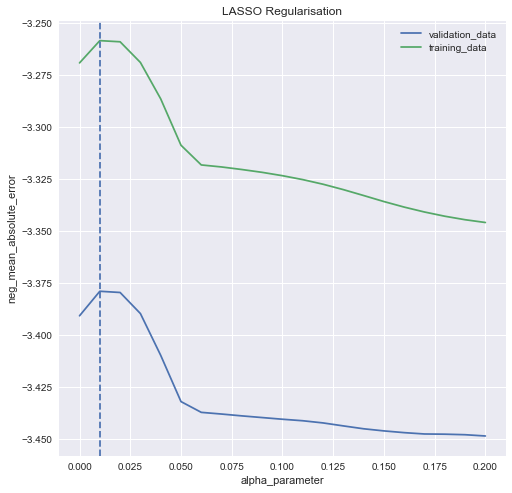

Chosen alpha: 0.01000
Validation score: -3.37896


In [18]:
chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test(
        lasso_alphas, X, y, cv, scoring = 'neg_mean_absolute_error', 
        model_name = 'LASSO', X_test = None, y_test = None, draw_plot = True, 
        filename= 'housing_mae_notscaled')

print("Chosen alpha: %.5f" % chosen_alpha)
print("Validation score: %.5f" % max_validation_score)

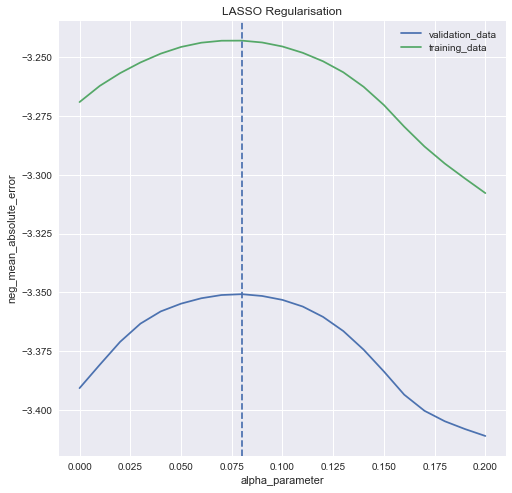

Chosen alpha: 0.08000
Validation score: -3.35080


In [19]:
chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test(
        lasso_alphas, X_scaled, y, cv, scoring = 'neg_mean_absolute_error', 
        model_name = 'LASSO', X_test = None, y_test = None, draw_plot = True, 
        filename = 'housing_mae_scaled')

print("Chosen alpha: %.5f" % chosen_alpha)
print("Validation score: %.5f" % max_validation_score)

# LassoCV

In [20]:
lasso = LassoCV(alphas=lasso_alphas, cv=cv, n_jobs=-1)
lasso.fit(X, y)
print('alpha: %.5f' % lasso.alpha_)

alpha: 0.00000


In [21]:
lasso.score(X, y)

0.7406426641094094

In [22]:
results = cross_validate(
    lasso, X, y, scoring='r2', cv=cv, return_train_score = True
)
np.mean(results['test_score'])

0.7107441126213843

Same as linreg? 

In [23]:
lr = LinearRegression()
lr.fit(X,y)
lr.score(X,y)

0.7406426641094094

In [24]:
lasso = LassoCV(alphas=lasso_alphas, cv=cv, n_jobs=-1)
# fit model
lasso.fit(X_scaled, y)
# summarize chosen configuration
print('alpha: %.5f' % lasso.alpha_)

alpha: 0.03000


In [25]:
lasso.score(X_scaled, y)

0.7401065268470196

In [26]:
results = cross_validate(
    lasso, X_scaled, y, scoring='r2', cv=cv, return_train_score = True
)
print("Validation score: %.5f" % np.mean(results['test_score']))
print("Training score: %.5f" % np.mean(results['train_score']))

Validation score: 0.71202
Training score: 0.74139


OK, but actually why didn'r lasso increase? 

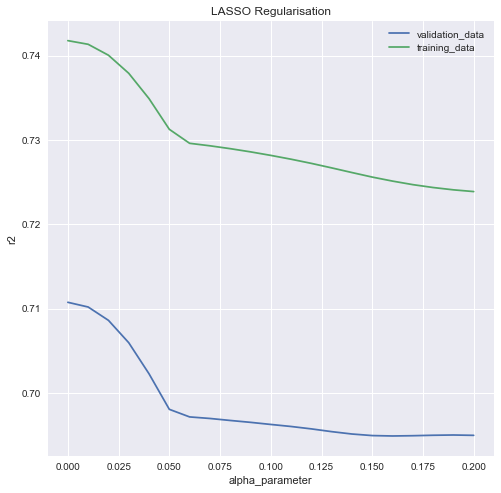

Chosen alpha: 0.00000
Validation score: 0.71074


In [101]:
chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test(
        lasso_alphas, X, y, cv, scoring = 'r2', 
        model_name = 'LASSO', X_test = None, y_test = None, draw_plot = True)

print("Chosen alpha: %.5f" % chosen_alpha)
print("Validation score: %.5f" % max_validation_score)

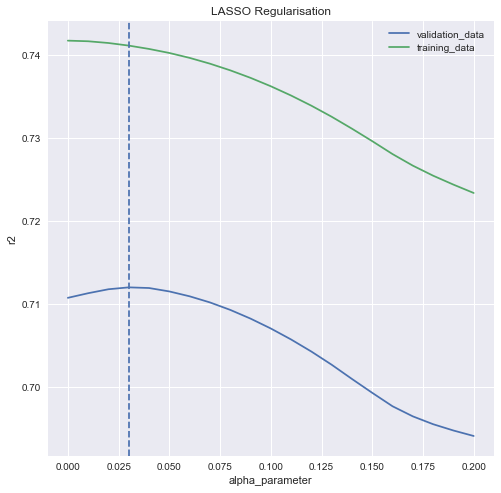

Chosen alpha: 0.03000
Validation score: 0.71201


In [29]:
chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test(
        lasso_alphas, X_scaled, y, cv, scoring = 'r2', 
        model_name = 'LASSO', X_test = None, y_test = None, draw_plot = True, 
        filename = 'housing_r2_scaled')

print("Chosen alpha: %.5f" % chosen_alpha)
print("Validation score: %.5f" % max_validation_score)

# Large Problem

In [32]:
df = pd.read_csv('../datasets/data_linreg.csv')

In [33]:
regression = LinearRegression()
cv = KFold(n_splits=5, shuffle=True, random_state= my_random_state)

In [34]:
y = df['poor_mental_health_days']
X = df.drop(['FIPS_state', 'FIPS_county', 'FIPS_full', 'state', 'county', 'year',
    'poor_mental_health_days'], axis = 1)

In [35]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=my_random_state)

In [36]:
poly = PolynomialFeatures(2, include_bias = False, interaction_only = False)
X_train_poly = poly.fit_transform(X_train)
polynomial_column_names = poly.get_feature_names(input_features = X_train.columns)
X_train_poly = pd.DataFrame(data =X_train_poly, columns = polynomial_column_names )

X_train_poly.columns = X_train_poly.columns.str.replace(' ', '_')
X_train_poly.columns = X_train_poly.columns.str.replace('^', '_')

In [37]:
sc = StandardScaler()
X_train_poly_scaled = sc.fit_transform(X_train_poly)
X_train_poly_scaled = pd.DataFrame(data = X_train_poly_scaled, columns = X_train_poly.columns)

In [40]:
poly_modelresults =  cross_validate(
    regression, X_train_poly_scaled, y_train, scoring='r2', cv=cv, return_train_score = True
)
poly_modelresults

{'fit_time': array([0.09728909, 0.0652597 , 0.05682015, 0.05541968, 0.05264735]),
 'score_time': array([0.00262499, 0.00225401, 0.00205684, 0.00206327, 0.00219679]),
 'test_score': array([0.79649803, 0.79308995, 0.66023128, 0.84461127, 0.78190355]),
 'train_score': array([0.88698161, 0.890758  , 0.88555462, 0.88532614, 0.8921823 ])}

In [41]:
X_test_poly = poly.transform(X_test)
X_test_poly_scaled = sc.transform(X_test_poly)

In [42]:
lasso=Lasso(alpha = 0.0006)
lasso.fit(X_train_poly_scaled, y_train)

Lasso(alpha=0.0006, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [43]:
lasso.score(X_test_poly_scaled, y_test)

0.8232583276196365

In [44]:
# alternative way of calculating it:
y_test_pred = lasso.predict(X_test_poly_scaled)
r2_score(y_test, y_test_pred)

0.8232583276196365

In [45]:
scorer = get_scorer('r2')
scorer(lasso, X_test_poly_scaled, y_test)

0.8232583276196365

In [46]:
lasso_alphas = np.linspace(0, 0.002, 11)

In [47]:
lasso_alphas_2 = np.linspace(0, 0.02, 11)

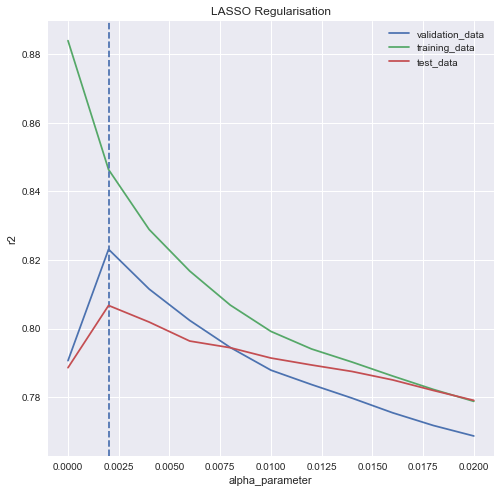

Chosen alpha: 0.00200
Validation score: 0.82310
Test score at chosen alpha: 0.80673


In [49]:
chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test(
        lasso_alphas_2, X_train_poly_scaled, y_train, cv, scoring = 'r2', 
        model_name = 'LASSO', X_test = X_test_poly_scaled, y_test = y_test, 
        draw_plot = True, filename = 'lasso_wide_search')

print("Chosen alpha: %.5f" % chosen_alpha)
print("Validation score: %.5f" % max_validation_score)
print("Test score at chosen alpha: %.5f" % test_score_at_chosen_alpha)

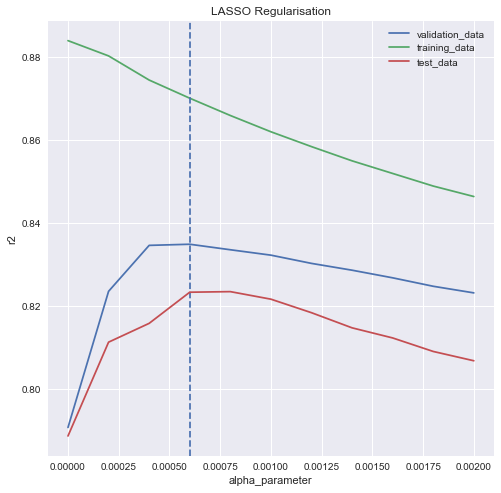

Chosen alpha: 0.00060
Validation score: 0.83483
Test score at chosen alpha: 0.82326


In [50]:
chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test(
        lasso_alphas, X_train_poly_scaled, y_train, cv, scoring = 'r2', 
        model_name = 'LASSO', X_test = X_test_poly_scaled, y_test = y_test, 
        draw_plot = True, filename = 'lasso_narrow_search')

print("Chosen alpha: %.5f" % chosen_alpha)
print("Validation score: %.5f" % max_validation_score)
print("Test score at chosen alpha: %.5f" % test_score_at_chosen_alpha)

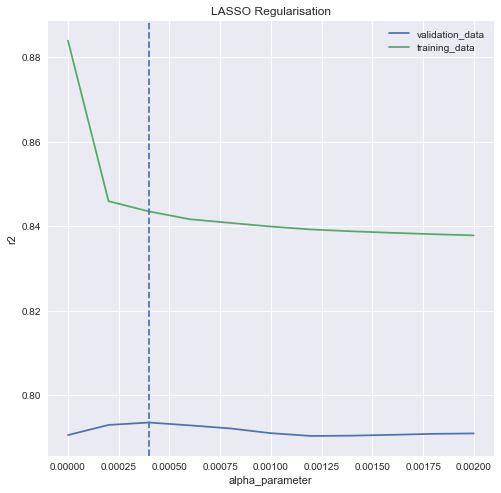

Chosen alpha: 0.00040
Validation score: 0.79361


In [135]:
# one last time why you should not use unscaled: 
chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test(
        lasso_alphas, X_train_poly, y_train, cv, scoring = 'r2', 
        model_name = 'LASSO', X_test = None, y_test = None, draw_plot = True)

print("Chosen alpha: %.5f" % chosen_alpha)
print("Validation score: %.5f" % max_validation_score)

# Ridge

In [51]:
ridge_alphas = np.linspace(5, 105, 11)

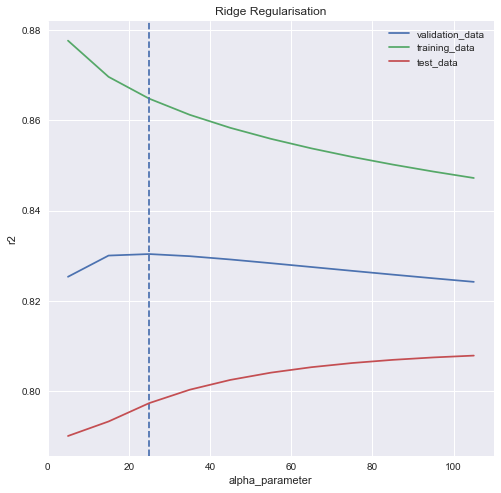

Chosen alpha: 25.00000
Validation score: 0.83037
Test score at chosen alpha: 0.79731


In [52]:
chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test(
        ridge_alphas, X_train_poly_scaled, y_train, cv, scoring = 'r2', 
        model_name = 'Ridge', X_test = X_test_poly_scaled, y_test = y_test, 
        draw_plot = True, filename = 'ridge_narrow_search')

print("Chosen alpha: %.5f" % chosen_alpha)
print("Validation score: %.5f" % max_validation_score)
print("Test score at chosen alpha: %.5f" % test_score_at_chosen_alpha)

In [143]:
ridge = Ridge(alpha = 0)

In [144]:
ridge.fit(X_train_poly_scaled, y_train)

Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [145]:
ridge.score(X_test_poly_scaled, y_test)

0.8114516664532715

In [146]:
lasso = Lasso(alpha = 0)

In [147]:
lasso.fit(X_train_poly_scaled, y_train)

Lasso(alpha=0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [148]:
lasso.score(X_test_poly_scaled, y_test)

0.7885846085730789

In [151]:
linreg = LinearRegression()
linreg.fit(X_train_poly_scaled, y_train)
linreg.score(X_test_poly_scaled, y_test)

0.8112562712479416

In [152]:
ridge = Ridge(alpha = 0)
ridge.fit(X_train_poly_scaled, y_train)
ridge.score(X_test_poly_scaled, y_test)

0.8114516664532715

In [153]:
lasso = Lasso(alpha = 0)
lasso.fit(X_train_poly_scaled, y_train)
lasso.score(X_test_poly_scaled, y_test)

0.7885846085730789